In [25]:
from pathlib import Path
import h5py
import numpy as np
from icecream import ic  # easy printing for debugging
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

import syft as sy
from syft.core.node.vm.vm import VirtualMachine
from syft.core.node.vm.client import VirtualMachineClient
from syft.ast.module import Module
from syft.core.remote_dataloader import RemoteDataLoader
from syft.core.remote_dataloader import RemoteDataset

print(f'torch version: {torch.__version__}')
print(f'syft version: {sy.__version__}')


torch version: 1.8.1+cu102
syft version: 0.5.0


## Files and Directories

In [26]:
project_path = Path.cwd()
print(f'project_path: {project_path}')

project_path: /mnt/batch/tasks/shared/LS_root/mounts/clusters/teslak80-56gbram/code/Users/dkn.work/priv-sec-ai-blog/ecg-split-1DCNN-PySyft


In [27]:
# paths to files and directories
train_name = 'train_ecg.hdf5'
test_name = 'test_ecg.hdf5'
dry_run = False  # load less data (50 examples)

## Construct the client and server

In [28]:
server: VirtualMachine = sy.VirtualMachine(name="server")
client: VirtualMachineClient = server.get_root_client()
remote_torch: Module = client.torch

## Client: loading and exploring the dataset

In [29]:
class ECG(Dataset):
    # The class used to load the ECG dataset
    def __init__(self, mode='train'):
        if mode == 'train':
            with h5py.File(project_path/train_name, 'r') as hdf:
                if dry_run:
                    self.x = torch.tensor(hdf['x_train'][:50], dtype=torch.float)
                    self.y = torch.tensor(hdf['y_train'][:50])
                else:
                    self.x = torch.tensor(hdf['x_train'][:], dtype=torch.float)
                    self.y = torch.tensor(hdf['y_train'][:])
        elif mode == 'test':
            with h5py.File(project_path/test_name, 'r') as hdf:
                if dry_run:
                    self.x = torch.tensor(hdf['x_test'][:50], dtype=torch.float)
                    self.y = torch.tensor(hdf['y_test'][:50])
                else:
                    self.x = torch.tensor(hdf['x_test'][:], dtype=torch.float)
                    self.y = torch.tensor(hdf['y_test'][:])
        else:
            raise ValueError('Argument of mode should be train or test')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [30]:
train_dataset = ECG(mode='train')
test_dataset = ECG(mode='test')

Let's first get everything in the dataset and see how many examples we have, and how each
of them look like

In [31]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))
print(f'x_train: {type(x_train)}, {x_train.size()}')
print(f'y_train: {type(y_train)}, {y_train.size()}')
print(f'x_test: {type(x_test)}, {x_test.size()}')
print(f'y_test: {type(y_test)}, {y_test.size()}')

x_train: <class 'torch.Tensor'>, torch.Size([13245, 1, 128])
y_train: <class 'torch.Tensor'>, torch.Size([13245])
x_test: <class 'torch.Tensor'>, torch.Size([13245, 1, 128])
y_test: <class 'torch.Tensor'>, torch.Size([13245])


In [32]:
y_train

tensor([2, 4, 2,  ..., 1, 4, 0])

In [33]:
def plot_ecg(x: torch.Tensor, y:torch.Tensor):
    x = x.view(-1)  # unroll into a list
    indx = np.arange(0, 128)
    plt.plot(x)
    plt.title(f'Class: {y}')
    plt.show()

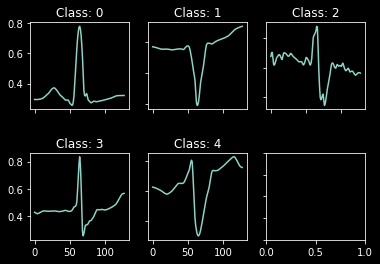

In [34]:
def plot_ecg():
    x = np.arange(0, 128)
    fig, axs = plt.subplots(2, 3)
    axs[0, 0].plot(x_train[-1].view(-1))
    axs[0, 0].set_title(f'Class: {y_train[-1]}')
    axs[0, 1].plot(x_train[5].view(-1))
    axs[0, 1].set_title(f'Class: {y_train[5]}')
    axs[0, 2].plot(x_train[0].view(-1))
    axs[0, 2].set_title(f'Class: {y_train[0]}')
    axs[1, 0].plot(x_train[14].view(-1))
    axs[1, 0].set_title(f'Class: {y_train[14]}')
    axs[1, 1].plot(x_train[1].view(-1))
    axs[1, 1].set_title(f'Class: {y_train[1]}')

    fig.subplots_adjust(hspace=0.5)
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

plot_ecg()

The client creates the Dataset object and save it in a `.pt` file. 
If using `duet`, he can send the string path to the server using 
`sy.lib.python.String(string_path).send(duet, pointable=True, tags=["data"])`

In [35]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

## Server: creating remote dataset and dataloader

In [36]:
train_rds = RemoteDataset(path='train_dataset.pt', data_type="torch_tensor")
train_rds

<class 'syft.core.remote_dataloader.remote_dataloader.RemoteDataset'>: torch_tensor

From the remote dataset, the server constructs the data loader. Then the server uses `.send`
to create a pointer to do remote data loading

In [37]:
train_rdl = RemoteDataLoader(remote_dataset=train_rds, batch_size=32)
train_rdl_ptr = train_rdl.send(client)
ic(train_rdl, train_rdl_ptr)
# call create_dataset to create the real Dataset object on remote side
train_rdl_ptr.load_dataset()
# call create_dataloader to create the real DataLoader object on remote side
train_rdl_ptr.create_dataloader()

ic| train_rdl: <syft.core.remote_dataloader.remote_dataloader.RemoteDataLoader object at 0x7fcc491a4bb0>
    train_rdl_ptr: <syft.proxy.syft.core.remote_dataloader.RemoteDataLoaderPointer object at 0x7fcc490a5340>


In [38]:
for i, b in enumerate(train_rdl_ptr):
    if dry_run:
        X, y = b[0], b[1]
        ic(X, y)
        ic(X.get_copy().shape, y.get_copy().shape)

Similarly, for the test dataset

In [39]:
test_rds = RemoteDataset(path='test_dataset.pt', data_type="torch_tensor")
test_rdl = RemoteDataLoader(remote_dataset=test_rds, batch_size=32)
test_rdl_ptr = test_rdl.send(client)
ic(test_rds, test_rdl, test_rdl_ptr)
# call create_dataset to create the real Dataset object on remote side
test_rdl_ptr.load_dataset()
# call create_dataloader to create the real DataLoader object on remote side
test_rdl_ptr.create_dataloader()

ic| test_rds: <class 'syft.core.remote_dataloader.remote_dataloader.RemoteDataset'>: torch_tensor
    test_rdl: <syft.core.remote_dataloader.remote_dataloader.RemoteDataLoader object at 0x7fcc491a4c40>
    test_rdl_ptr: <syft.proxy.syft.core.remote_dataloader.RemoteDataLoaderPointer object at 0x7fcc4918ce50>


In [40]:
for i, b in enumerate(test_rdl_ptr):
    if dry_run:
        X, y = b[0], b[1]
        ic(X, y)
        ic(X.get_copy().shape, y.get_copy().shape)

## Server: define the spit neural network used to train on the ECG dataset

Client's side contains conv layers

In [41]:
class EcgClient(sy.Module):
    # used by the data owners
    def __init__(self, torch_ref):
        super(EcgClient, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = self.torch_ref.nn.LeakyReLU()
        self.pool1 = self.torch_ref.nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = self.torch_ref.nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = self.torch_ref.nn.LeakyReLU()
        self.pool2 = self.torch_ref.nn.MaxPool1d(2)  # 32 x 16
        # load initial weights
        checkpoint = torch.load("init_weight.pth")
        self.conv1.weight.data = checkpoint["conv1.weight"]
        self.conv1.bias.data = checkpoint["conv1.bias"]
        self.conv2.weight.data = checkpoint["conv2.weight"]
        self.conv2.bias.data = checkpoint["conv2.bias"]
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 16)
        return x

Server's side contains fully connected layers

In [42]:
class EcgServer(sy.Module):
    def __init__(self, torch_ref):
        super(EcgServer, self).__init__(torch_ref=torch_ref)
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU() 
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
        
        checkpoint = torch.load("init_weight.pth")
        self.linear3.weight.data = checkpoint["linear3.weight"]
        self.linear3.bias.data = checkpoint["linear3.bias"]
        self.linear4.weight.data = checkpoint["linear4.weight"]
        self.linear4.bias.data = checkpoint["linear4.bias"]
        
    def forward(self, x):
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.softmax4(x)
        return x

## Server: training process

In [43]:
ecg_client = EcgClient(torch_ref=torch)
ecg_client_ptr = ecg_client.send(client)  # Send the client's model to the client
ecg_server = EcgServer(torch_ref=torch)

Some hyper-parameters

In [44]:
total_batch = 414  # 32*414=13248. We have 13245 data samples

epoch = 400
criterion = nn.CrossEntropyLoss()
lr = 0.001

optim_client = remote_torch.optim.Adam(params=ecg_client_ptr.parameters(), lr=lr)
optim_server = torch.optim.Adam(params=ecg_server.parameters(), lr=lr)

seed = 0  # the meaning of life
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
remote_torch.manual_seed(seed)

Training (with CPU)

In [48]:
train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy
for e in range(epoch):
    print(f"Epoch {e+1} - train ", end='')
    
    train_loss = 0.0
    correct, total = 0, 0
    for i, batch in enumerate(train_rdl_ptr):
        x_ptr, y_gt_ptr = batch[0], batch[1]
        # ic(x.get_copy(), y.get_copy())
        # initialize all gradients to zero
        optim_server.zero_grad()
        optim_client.zero_grad()
        # compute and get the activation signals from the first half of the network
        activs_ptr = ecg_client_ptr(x_ptr)
        # the client sends the activation maps to the server
        activs = activs_ptr.clone().get(request_block=True)
        # the server continues the forward pass on the activation maps
        y_hat = ecg_server(activs)
        # the server asks to access ground truths in plain text
        y_gt = y_gt_ptr.get_copy()
        # calculates cross-entropy loss
        loss = criterion(y_hat, y_gt)
        train_loss += loss.item()
        correct += torch.sum(y_hat.argmax(dim=1) == y_gt).item()
        # backward propagation (calculating gradients of the loss w.r.t the weights)
        loss.backward()
        # send the gradients to the client
        client_grad_ptr = activs.grad.clone().send(client)
        # update the gradients of the client's model
        activs_ptr.backward(client_grad_ptr)
        # update the weights based on the gradients
        optim_client.step()
        optim_server.step()
        total += len(y_gt)

    train_losses.append(train_loss / total_batch)
    train_accs.append(correct / total)

    print(f'loss: {train_losses[-1]: .4f}, accuracy: {train_accs[-1]*100: 2f}')

    # testing
    with torch.no_grad():  
        test_loss = 0.0
        correct, total = 0, 0
        for i, batch in enumerate(test_rdl_ptr):
            x_ptr, y_gt_ptr = batch[0], batch[1]
            # forward pass
            activs_ptr = ecg_client_ptr(x_ptr)
            activs = activs_ptr.clone().get(request_block=True)
            y_hat = ecg_server(activs)
            # the server asks to access ground truths in plain text
            y_gt = y_gt_ptr.get_copy()
            # calculate test loss
            loss = criterion(y_hat, y_gt)
            test_loss += loss.item()
            correct += torch.sum(y_hat.argmax(dim=1) == y_gt).item()
            total += len(y_gt)

        test_losses.append(test_loss / total_batch)
        test_accs.append(correct / total)
        print(f'test_loss: {test_losses[-1]: .4f}, test_acc: {test_accs[-1]*100: 2f}')
        
    if test_accs[-1] > best_test_acc:
        best_test_acc = test_accs[-1]

Epoch 1 - train 

/anaconda/envs/SyftEnv/lib/python3.9/site-packages/syft/lib/torch/uppercase_tensor.py:30: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  grad = getattr(obj, "grad", None)


loss:  1.0200, accuracy:  88.456021
test_loss:  1.0147, test_acc:  89.052473
Epoch 2 - train loss:  1.0179, accuracy:  88.705172
test_loss:  1.0149, test_acc:  88.976972
Epoch 3 - train loss:  1.0186, accuracy:  88.554171
test_loss:  1.0138, test_acc:  88.992072
Epoch 4 - train loss:  1.0172, accuracy:  88.629672
test_loss:  1.0131, test_acc:  89.127973
Epoch 5 - train loss:  1.0165, accuracy:  88.712722
test_loss:  1.0107, test_acc:  89.346923
Epoch 6 - train loss:  1.0144, accuracy:  88.931672
test_loss:  1.0133, test_acc:  89.037373
Epoch 7 - train loss:  1.0130, accuracy:  89.090223
test_loss:  1.0077, test_acc:  89.588524
Epoch 8 - train loss:  1.0106, accuracy:  89.309173
test_loss:  1.0057, test_acc:  89.837675
Epoch 9 - train loss:  1.0102, accuracy:  89.324273
test_loss:  1.0074, test_acc:  89.565874
Epoch 10 - train loss:  1.0090, accuracy:  89.422424
test_loss:  1.0063, test_acc:  89.731974
Epoch 11 - train loss:  1.0083, accuracy:  89.573424
test_loss:  1.0041, test_acc:  8

In [52]:
best_test_acc_epoch = np.array(test_accs).argmax() + 1
print('Best test accuracy {:.2f}% in epoch {}.'.format(best_test_acc*100, best_test_acc_epoch))

Best test accuracy 98.85% in epoch 351.


Save train and test losses and accuracies to a `.csv` file 

In [53]:
import pandas as pd
import os
df = pd.DataFrame({  # save model training process into csv file
        'loss': train_losses,
        'test_loss': test_losses,
        'acc': train_accs,
        'test_acc': test_accs
    })
df.to_csv('loss_and_acc.csv')

Plotting losses and accuracies

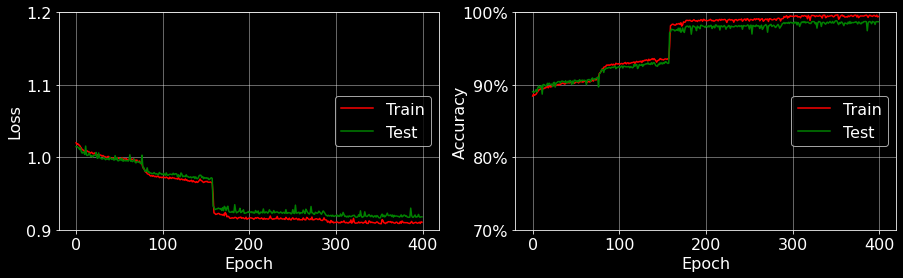

In [54]:
df = pd.read_csv('loss_and_acc.csv')
test_accs = df['test_acc']
train_accs = df['acc']
test_losses = df['test_loss']
train_losses = df['loss']

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(train_losses, color='red')
ax[0].plot(test_losses, color='green')
ax[0].set_xticks([0, 100, 200, 300, 400])
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Loss', size=16)
ax[0].set_ylim(0.9, 1.1)
ax[0].set_yticks([0.9, 1.0, 1.1, 1.2])
ax[0].grid(alpha=0.5)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Train', 'Test'], loc='right', fontsize=16)


ax[1].set_ylim(0.7, 1.0)
ax[1].set_yticks([0.7, 0.8, 0.9, 1.0])
ax[1].plot(train_accs, color='red')
ax[1].plot(test_accs, color='green')
yt = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in yt])
ax[1].set_xticks([0, 100, 200, 300, 400])
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Accuracy', size=16, labelpad=-5)
ax[1].grid(alpha=0.5)
ax[1].tick_params(labelsize=16)
ax[1].legend(['Train', 'Test'], loc='right', fontsize=16)

fig.savefig('loss_acc_conv2_split_seed.pdf', bbox_inches='tight')